In [109]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
import json
import math
import gzip
#!pip install seaborn
import seaborn as sns
import datetime
from IPython.display import Image
import scipy.stats as stats
from scipy.stats import t
from statsmodels.tsa.stattools import adfuller


from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

In [110]:
# Font size to 14
matplotlib.rc('font', size = 14)
# Do not display top and right frame lines
matplotlib.rc('axes.spines', top = False, right = False)
# Remove grid lines
matplotlib.rc('axes', grid = False)
# Set backgound color to white
matplotlib.rc('axes', facecolor = 'white')
# Plot size
matplotlib.rc('figure', figsize = (10, 6))

In [111]:
## Read CSV data and convert to pandas dataframe

df = pd.read_csv("ratings_Clothing_Shoes_and_Jewelry.csv",names = ["reviewerID", "asin", "overall", "unixReviewTime"])

In [112]:
df.head()

,reviewerID,asin,overall,unixReviewTime
0,A2XVJBSRI3SWDI,0000031887,5.0,1383523200
1,A2G0LNLN79Q6HR,0000031887,4.0,1337990400
2,A2R3K1KX09QBYP,0000031887,2.0,1361059200
3,A19PBP93OF896,0000031887,1.0,1363824000
4,A1P0IHU93EF9ZK,0000031887,4.0,1390435200


In [113]:
len(df)

5748920

In [131]:
## Functions

def convert_unix(df, col):
    temp_array = []
    day = []
    month = []
    year = []
    hour = []
    minute = []
    for i,row in df.iterrows():
        unix = row[col]
        d = datetime.datetime.fromtimestamp(int(unix))
        day.append(d.day)
        month.append(d.month)
        year.append(d.year)
        hour.append(d.hour)
        minute.append(d.minute)
        temp_array.append(d)
    df['datetime'] = temp_array
    df['date'] = [time.date() for time in df['datetime']]
    df['year'] = year
    df['month'] = month
    df['day'] = day
    df['hour'] = hour
    df['minute'] = minute

def drop_unnecessary_columns(df):
    new_df = df
    new_df = new_df.drop('unixReviewTime' ,axis=1)
    return new_df

def data_wrangling(df):
    convert_unix(df,'unixReviewTime')
    df = drop_unnecessary_columns(df)
    return df

def testStatistic(df):
    mu = np.mean(df['overall'])
    sigma = np.std(df['overall'])
    var = np.var(df['overall'])
    tstat = (mu - np.mean(reviews['overall'][reviews['year']>2006]))/ math.sqrt(sigma / len(df))
    pval = float(stats.t.sf(np.abs(tstat), len(df)-1)*2)
    return tstat, pval, var, mu, sigma

def testStatisticTime(df):
    mu = np.mean(df['overall'])
    sigma = np.std(df['overall'])
    var = np.var(df['overall'])
    mean_p = np.mean(reviews['overall'][reviews['date']<min(df['date'])])
    tstat = (mu - mean_p)/ math.sqrt(sigma / len(df))
    pval = float(stats.t.sf(np.abs(tstat), len(df)-1)*2)
    return tstat, pval, var, mu, sigma

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

In [115]:
reviews = data_wrangling(df)

In [116]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5748920 entries, 0 to 5748919
Data columns (total 10 columns):
reviewerID    object
asin          object
overall       float64
datetime      datetime64[ns]
date          object
year          int64
month         int64
day           int64
hour          int64
minute        int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 438.6+ MB


In [117]:
reviews.head()

,reviewerID,asin,overall,datetime,date,year,month,day,hour,minute
0,A2XVJBSRI3SWDI,0000031887,5.0,2013-11-03 16:00:00,2013-11-03,2013,11,3,16,0
1,A2G0LNLN79Q6HR,0000031887,4.0,2012-05-25 17:00:00,2012-05-25,2012,5,25,17,0
2,A2R3K1KX09QBYP,0000031887,2.0,2013-02-16 16:00:00,2013-02-16,2013,2,16,16,0
3,A19PBP93OF896,0000031887,1.0,2013-03-20 17:00:00,2013-03-20,2013,3,20,17,0
4,A1P0IHU93EF9ZK,0000031887,4.0,2014-01-22 16:00:00,2014-01-22,2014,1,22,16,0


In [132]:
## Use a for loop to create a dictionary of smaller dataframes organized by month and year

year = [2007,2008,2009,2010,2011,2012,2013,2014]
month = range(1,13)
datasets = []

for y in year:
    df_year = reviews[reviews['year'] == y]
    for m in month:
        df_month_year = df_year[df_year['month'] == m]
        if len(df_month_year)>1:
            datasets.append(df_month_year)

In [133]:
test_statistic = pd.DataFrame(columns=['tstat','pval','var','mean','stddev'])

for i in datasets:
    results = testStatistic(i)
    test_statistic = test_statistic.append({'tstat':results[0],'pval': results[1],'var': results[2],'mean': results[3],'stddev': results[4]}\
                                           ,ignore_index=True)

### Limitations

* We don't have additional item attribute data, such as product type or item category
* We don't have any additional user information, such as product purchase history, dollar amount spent, number of logins, etc.

## Exploratory Data Analysis

In [80]:
## Check for Null Values

cols = reviews.columns

for c in cols:
    print(c)
    nulls = float(reviews[c].isnull().sum())
    print('Nulls')
    print(nulls)
    print('******************************')

reviewerID
Nulls
0.0
******************************
asin
Nulls
0.0
******************************
overall
Nulls
0.0
******************************
datetime
Nulls
0.0
******************************
date
Nulls
0.0
******************************
year
Nulls
0.0
******************************
month
Nulls
0.0
******************************
day
Nulls
0.0
******************************
hour
Nulls
0.0
******************************
minute
Nulls
0.0
******************************


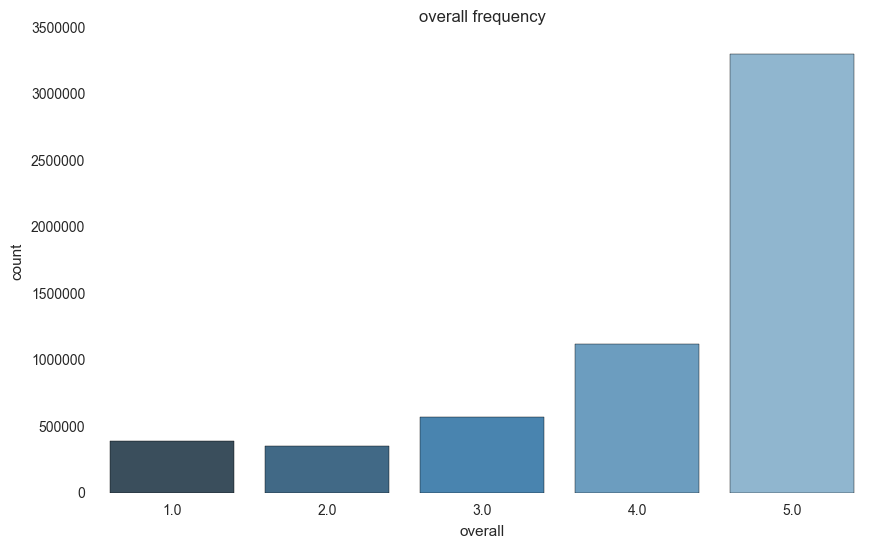

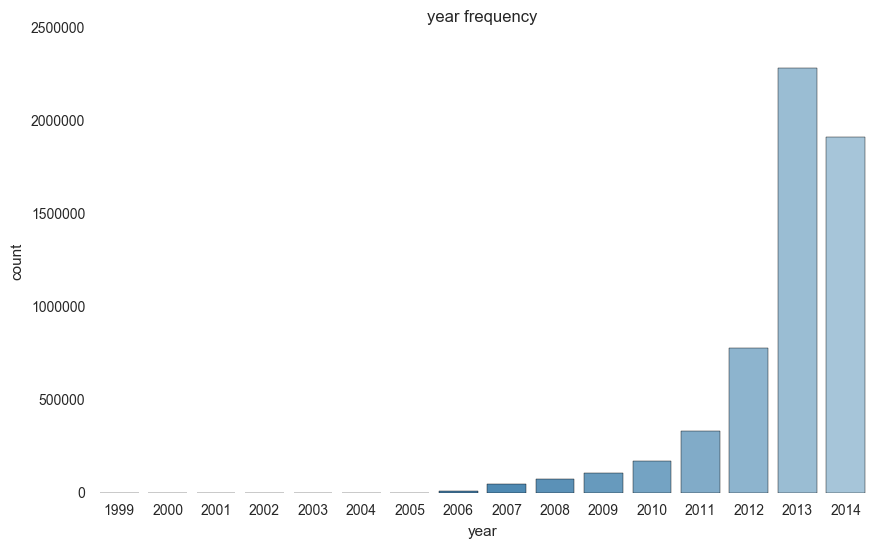

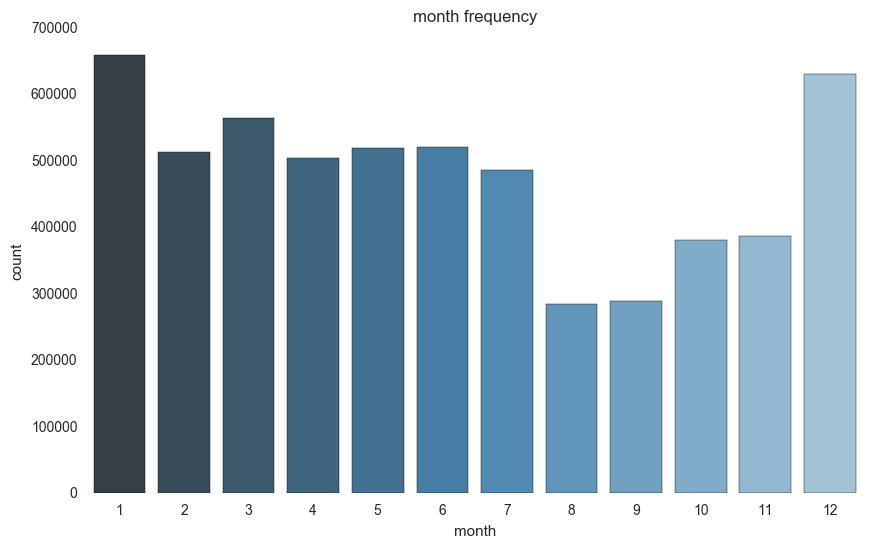

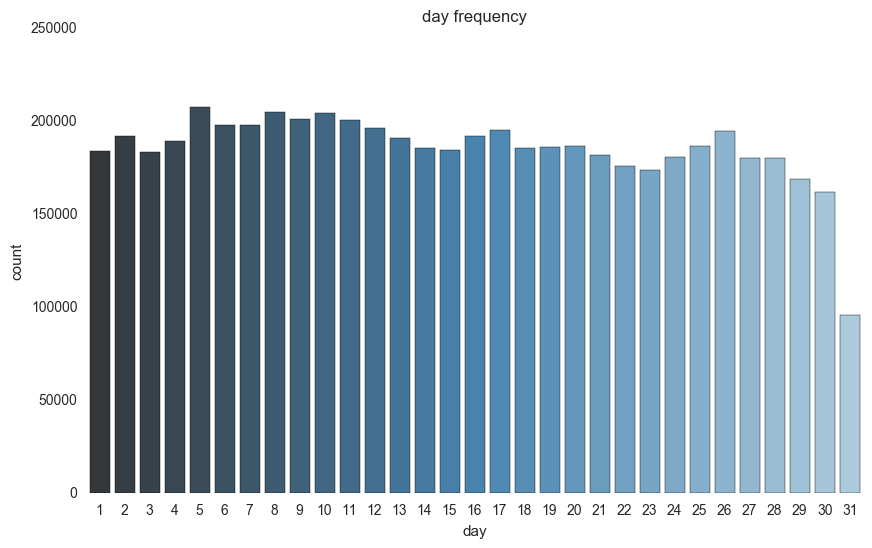

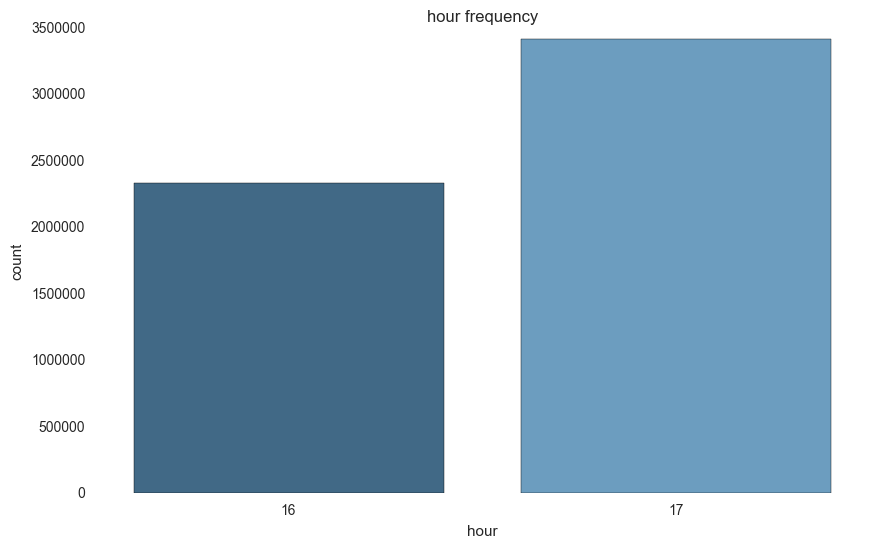

In [81]:
counts = ['overall','year','month','day','hour']

for c in counts:
    sns.countplot(c, data=reviews, palette="Blues_d")
    plt.title('%s frequency' %c)
    plt.show()

In [82]:
reviews.describe()

,overall,year,month,day,hour,minute
count,5.748920e+06,5.748920e+06,5.748920e+06,5.748920e+06,5.748920e+06,5748920.0
mean,4.144679e+00,2.012773e+03,6.104234e+00,1.544674e+01,1.659428e+01,0.0
std,1.233103e+00,1.426108e+00,3.613425e+00,8.734617e+00,4.910302e-01,0.0
min,1.000000e+00,1.999000e+03,1.000000e+00,1.000000e+00,1.600000e+01,0.0
25%,4.000000e+00,2.012000e+03,3.000000e+00,8.000000e+00,1.600000e+01,0.0
50%,5.000000e+00,2.013000e+03,6.000000e+00,1.500000e+01,1.700000e+01,0.0
75%,5.000000e+00,2.014000e+03,9.000000e+00,2.300000e+01,1.700000e+01,0.0
max,5.000000e+00,2.014000e+03,1.200000e+01,3.100000e+01,1.700000e+01,0.0


## Analyzing Review Ratings by Year

In [83]:
reviews['month'] = reviews['month'].astype(str)
reviews['year'] = reviews['year'].astype(str)

In [84]:
reviews['month-year'] = reviews[['month', 'year']].apply(lambda x: '-'.join(x), axis=1)
reviews['year-month'] = reviews['month-year'].apply(lambda x: pd.datetime.strptime(x, '%m-%Y'))

In [85]:
reviews['year_dt'] = reviews['year'].apply(lambda x: pd.datetime.strptime(x, '%Y'))

In [86]:
five_star_reviews = reviews[reviews['overall'] == 5]
four_star_reviews = reviews[reviews['overall'] == 4]
three_star_reviews = reviews[reviews['overall'] == 3]
two_star_reviews = reviews[reviews['overall'] == 2]
one_star_reviews = reviews[reviews['overall'] == 1]

separated_data = [five_star_reviews, four_star_reviews, three_star_reviews, two_star_reviews, one_star_reviews]

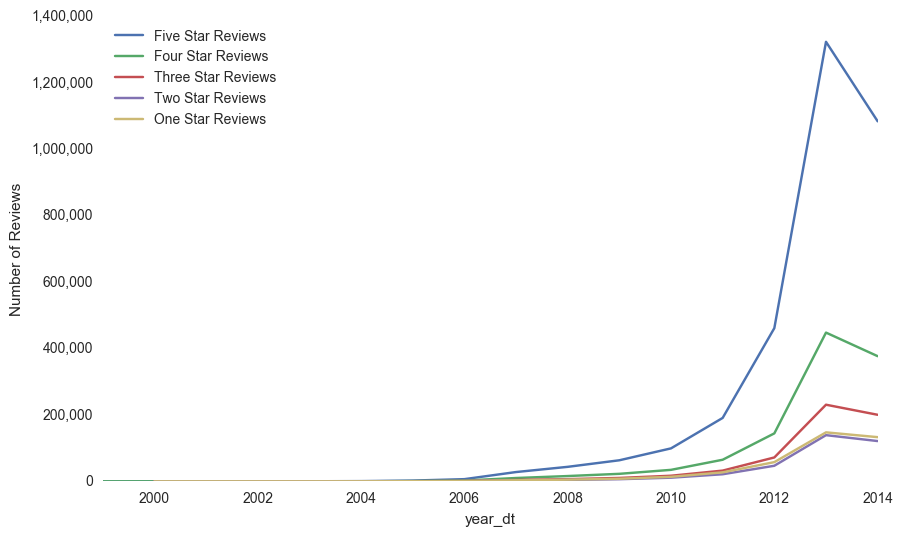

In [87]:
labels=['Five Star Reviews','Four Star Reviews','Three Star Reviews','Two Star Reviews','One Star Reviews']
i=0
for x in separated_data:
    x = x.sort_values(['date'])
    x.groupby(x['year_dt']).size().plot(label=labels[i])
    i+=1
plt.yticks([0,200000,400000,600000,800000,1000000,1200000,1400000], \
            ['0','200,000','400,000','600,000','800,000','1,000,000','1,200,000','1,400,000','1,600,000'])
plt.ylabel('Number of Reviews')
plt.legend(loc='best')
plt.show()

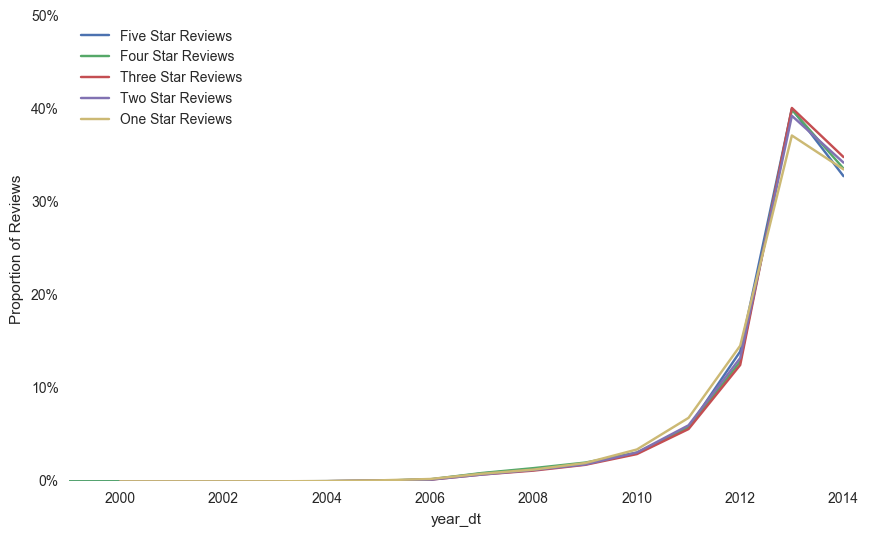

In [88]:
## Normalizing for Total Number of Reviews

labels=['Five Star Reviews','Four Star Reviews','Three Star Reviews','Two Star Reviews','One Star Reviews']
i=0
for x in separated_data:
    series = x['year_dt'].groupby(x['year_dt']).size()/len(x)
    series.plot(label=labels[i])
    i+=1

    plt.yticks([0,0.1,0.2,0.3,0.4,0.5],['0%','10%','20%','30%','40%','50%'])
plt.ylabel('Proportion of Reviews')
plt.legend(loc='best')
plt.show()

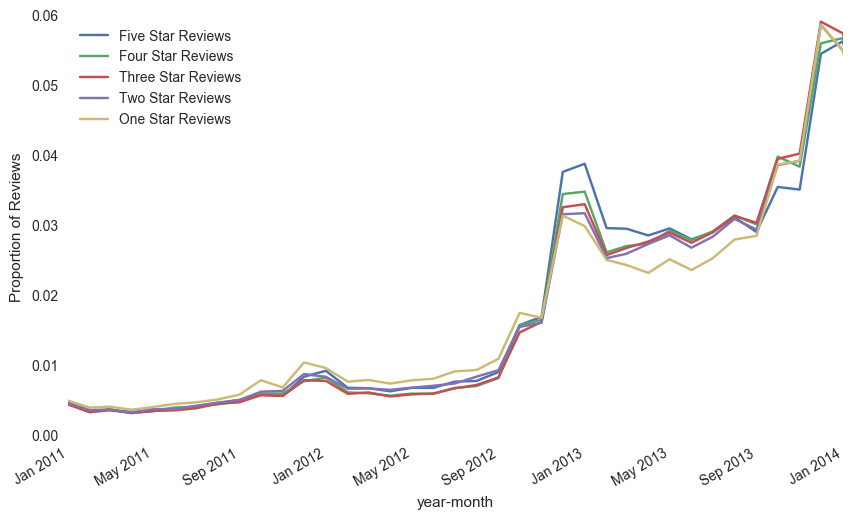

In [89]:
labels=['Five Star Reviews','Four Star Reviews','Three Star Reviews','Two Star Reviews','One Star Reviews']
i=0
for x in separated_data:
    series = x['year-month'].groupby(x['year-month']).size()/len(x)
    series.plot(label=labels[i])
    i+=1

#plt.yticks([0,0.1,0.2,0.3,0.4,0.5],['0%','10%','20%','30%','40%','50%'])
plt.ylabel('Proportion of Reviews')
plt.xlim('2011','2014')
plt.legend(loc='best')
plt.show()

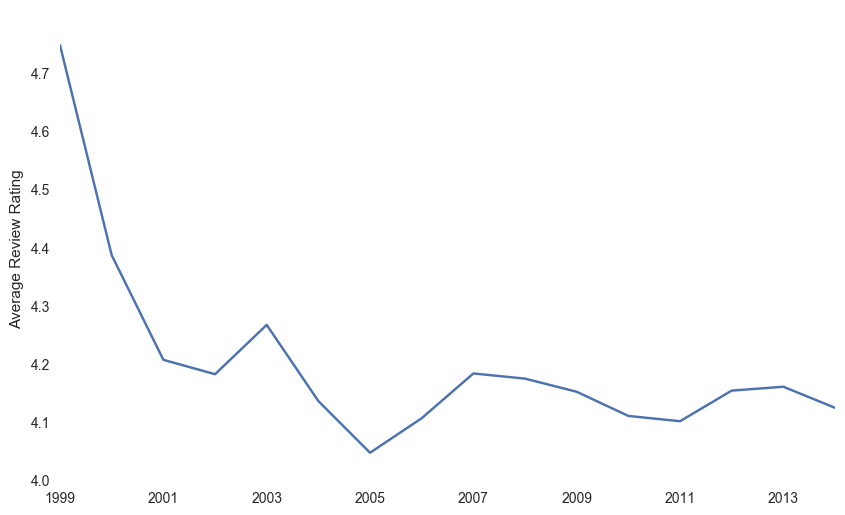

In [90]:
reviews.groupby('year').overall.mean().plot()
#plt.title('Average Review Rating Per Year is Declining')
plt.ylabel('Average Review Rating')
plt.xlabel('')
plt.show()

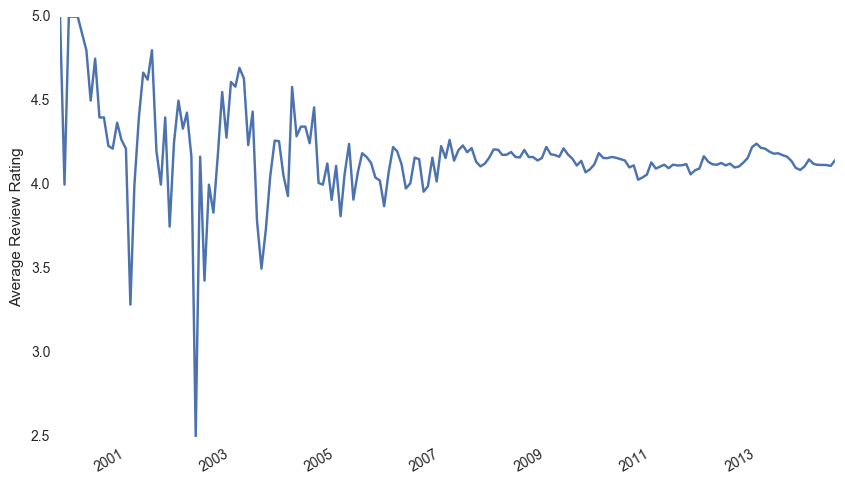

In [91]:
reviews.groupby('year-month').overall.mean().plot()
#plt.title('Average Review Rating Per Month-Year is Noisier in Earlier Years')
plt.ylabel('Average Review Rating')
plt.xlabel('')
plt.show()

In [92]:
reviews.groupby('year').overall.median()

year
1999    5.0
2000    5.0
2001    4.0
2002    5.0
2003    5.0
2004    5.0
2005    5.0
2006    5.0
2007    5.0
2008    5.0
2009    5.0
2010    5.0
2011    5.0
2012    5.0
2013    5.0
2014    5.0
Name: overall, dtype: float64

### Initial takeaways about the data
* There are no null values
* The data ranges from 1999 to 2014
* The majority of the data is from 2013 and 2014
* The unix time provided all converts to either 4pm or 5pm
* The vast majority of reviews did not have any responses for helpful or not helpful
* More than half the reviews are five star reviews
* Average review rating appears to be smooth over time
* All years except 2001 have a 5 star median rating

## Digging Deeper to Understand Fluctuations in Average Review Rating Over Time

In [93]:
reviews.head()

,reviewerID,asin,overall,datetime,date,year,month,day,hour,minute,month-year,year-month,year_dt
0,A2XVJBSRI3SWDI,0000031887,5.0,2013-11-03 16:00:00,2013-11-03,2013,11,3,16,0,11-2013,2013-11-01,2013-01-01
1,A2G0LNLN79Q6HR,0000031887,4.0,2012-05-25 17:00:00,2012-05-25,2012,5,25,17,0,5-2012,2012-05-01,2012-01-01
2,A2R3K1KX09QBYP,0000031887,2.0,2013-02-16 16:00:00,2013-02-16,2013,2,16,16,0,2-2013,2013-02-01,2013-01-01
3,A19PBP93OF896,0000031887,1.0,2013-03-20 17:00:00,2013-03-20,2013,3,20,17,0,3-2013,2013-03-01,2013-01-01
4,A1P0IHU93EF9ZK,0000031887,4.0,2014-01-22 16:00:00,2014-01-22,2014,1,22,16,0,1-2014,2014-01-01,2014-01-01


In [94]:
## Investigate total count per month and average rating per month over time
## The noisy fluctuations earlier in the timeseries are because of a small number of reviews per month

pd.options.display.max_rows = 200
size = reviews.groupby('year-month').size()
avg = reviews.groupby('year-month').overall.mean()
size = pd.DataFrame(size)
size.columns = ['Count']
avg = pd.DataFrame(avg)
avg.columns = ['Mean_Rating']
joined = pd.concat([size, avg], axis=1)
joined

,Count,Mean_Rating
year-month,,
1999-10-01,1,5.000000
1999-11-01,1,4.000000
1999-12-01,2,5.000000
2000-01-01,2,5.000000
2000-02-01,2,5.000000
2000-04-01,5,4.800000
2000-05-01,6,4.500000
2000-06-01,4,4.750000
2000-07-01,5,4.400000


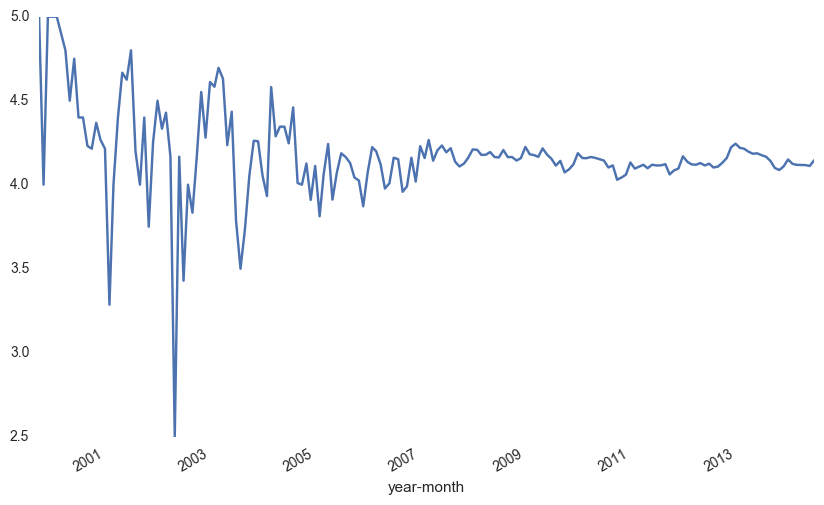

In [96]:
# Because counts are fewer than 500 per month prior to the year 2005, 
# this plot examines fluctuations only from 2006 onwards

later_reviews = reviews[reviews['year']>2006]
size = later_reviews.groupby('year-month').size()
avg = later_reviews.groupby('year-month').overall.mean()
size = pd.DataFrame(size)
size.columns = ['Count']
avg = pd.DataFrame(avg)
avg.columns = ['Mean_Rating']
joined = pd.concat([size, avg], axis=1)
joined['Mean_Rating'].plot()
#plt.title('Average Review Rating from 2012 Onwards')
plt.show()

In [97]:
joined.head()

,Count,Mean_Rating
year-month,,
1999-10-01,1,5.0
1999-11-01,1,4.0
1999-12-01,2,5.0
2000-01-01,2,5.0
2000-02-01,2,5.0


## Key Takeaways
* Fluctuations early on are due to few total monthly reviews.
* Some seasonality in the data fluctuations may exist.
* There may be a slight decline in mean review rating from late 2007 to mid 2014.

In [126]:
avg.reset_index(inplace=True)
avg['mean'] = avg['Mean_Rating']

In [135]:
test_statistic = pd.merge(test_statistic,avg)
test_statistic.drop('Mean_Rating',axis=1, inplace=True)

In [136]:
test_statistic.head()

,tstat,pval,var,mean,stddev,year-month
0,7.109974,1.257644e-12,1.366145,4.229490,1.168822,2007-01-01
1,0.660740,5.088332e-01,1.498238,4.158628,1.224025,2007-02-01
2,7.021898,2.582971e-12,1.293210,4.266508,1.137194,2007-03-01
3,-0.081353,9.351705e-01,1.513261,4.142701,1.230147,2007-04-01
4,3.607916,3.122361e-04,1.386440,4.205013,1.177472,2007-05-01


In [137]:
test_statistic.set_index('year-month',inplace=True)

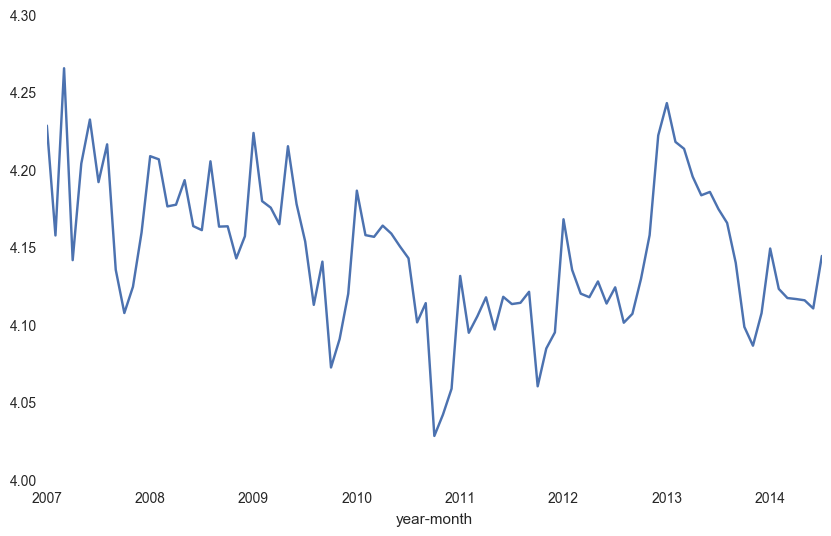

In [138]:
test_statistic['mean'].plot(kind='line')
plt.show()

## Time Series Modeling

In [142]:
len(test_statistic)

91

In [145]:
test_statistic['date'] = test_statistic.index

In [146]:
timeseries = test_statistic[['date','mean','var','stddev','pval']]

In [147]:
timeseries.set_index('date',inplace=True)

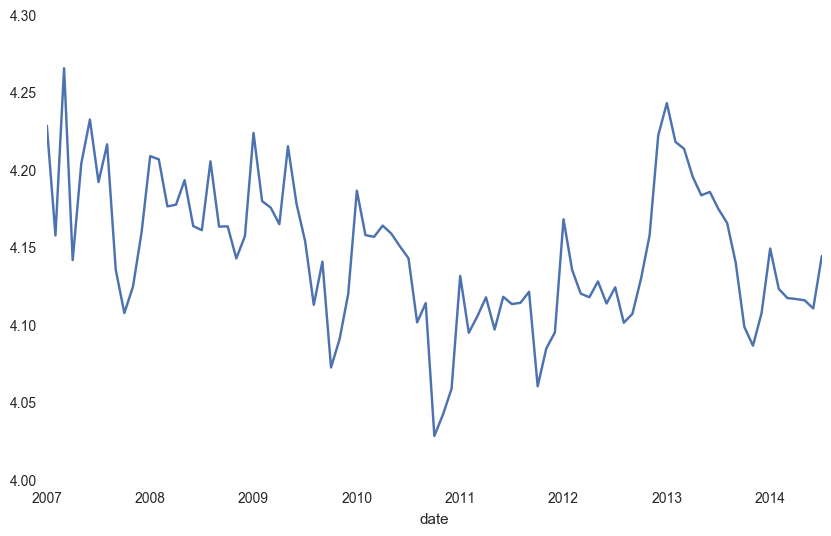

In [148]:
timeseries['mean'].plot()
plt.show()

In [236]:
len(timeseries)

91

In [237]:
train = timeseries.iloc[0: 67]
test = timeseries.iloc[67:]

In [238]:
train.head()

,mean,var,stddev,pval
date,,,,
2007-01-01,4.229490,1.366145,1.168822,1.257644e-12
2007-02-01,4.158628,1.498238,1.224025,5.088332e-01
2007-03-01,4.266508,1.293210,1.137194,2.582971e-12
2007-04-01,4.142701,1.513261,1.230147,9.351705e-01
2007-05-01,4.205013,1.386440,1.177472,3.122361e-04


In [239]:
test

,mean,var,stddev,pval
date,,,,
2012-08-01,4.102333,1.675925,1.294575,1.798581e-15
2012-09-01,4.108073,1.673669,1.293704,1.392734e-13
2012-10-01,4.130674,1.582713,1.258059,1.368651e-04
2012-11-01,4.158863,1.514581,1.230683,7.880629e-05
2012-12-01,4.223174,1.410866,1.187799,2.123993e-233
2013-01-01,4.244016,1.368890,1.169996,0.000000e+00
2013-02-01,4.218983,1.431778,1.196569,1.762804e-163
2013-03-01,4.214538,1.413936,1.189090,9.702491e-147
2013-04-01,4.196565,1.412106,1.188321,9.214394e-81


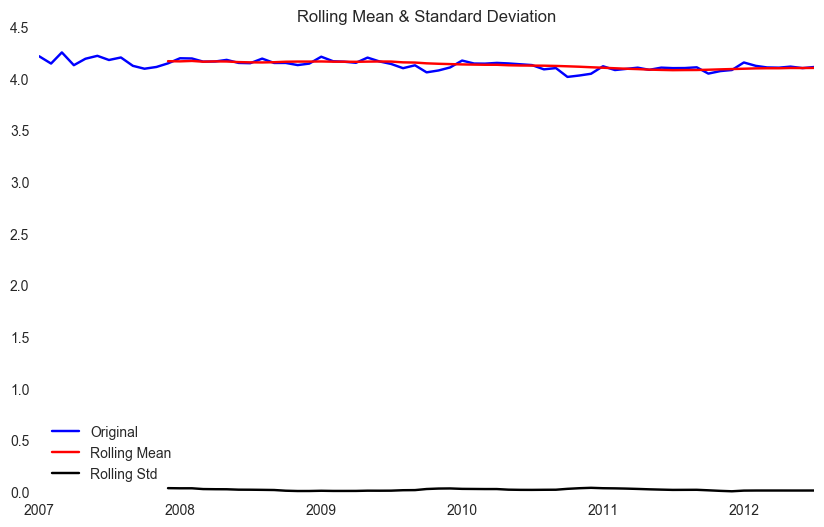

Results of Dickey-Fuller Test:
Test Statistic                 -0.786742
p-value                         0.822986
#Lags Used                     11.000000
Number of Observations Used    55.000000
Critical Value (5%)            -2.915731
Critical Value (1%)            -3.555273
Critical Value (10%)           -2.595670
dtype: float64


In [240]:
test_stationarity(train['mean'])

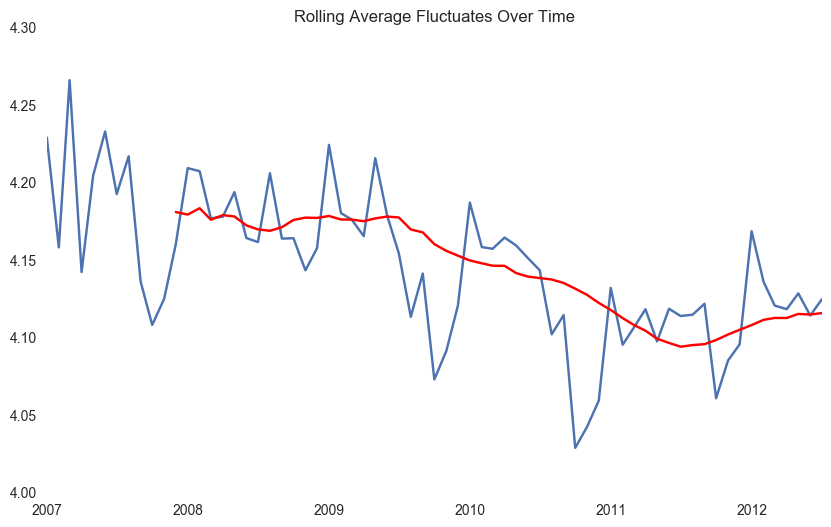

In [241]:
moving_avg = pd.rolling_mean(train['mean'],12)
plt.plot(train['mean'])
plt.plot(moving_avg, color='red')
plt.title('Rolling Average Fluctuates Over Time')
plt.show()

### Takeaways
* The rolling mean and standard deviation initially look fairly smooth
* The test statistic here is smaller than the Critical Value at 10%, but larger than that at 5% and 1%
* We can see that it's not as smooth as it looks initially when we view the chart with just the timeseries data and the rolling mean (removing rolling standard deviation)

## Methods to Make the TS Data Stationary 

### 1. Moving Average

In [242]:
ts_log_moving_avg_diff = train['mean'] - moving_avg
ts_log_moving_avg_diff.head(12)

date
2007-01-01         NaN
2007-02-01         NaN
2007-03-01         NaN
2007-04-01         NaN
2007-05-01         NaN
2007-06-01         NaN
2007-07-01         NaN
2007-08-01         NaN
2007-09-01         NaN
2007-10-01         NaN
2007-11-01         NaN
2007-12-01   -0.020871
Name: mean, dtype: float64

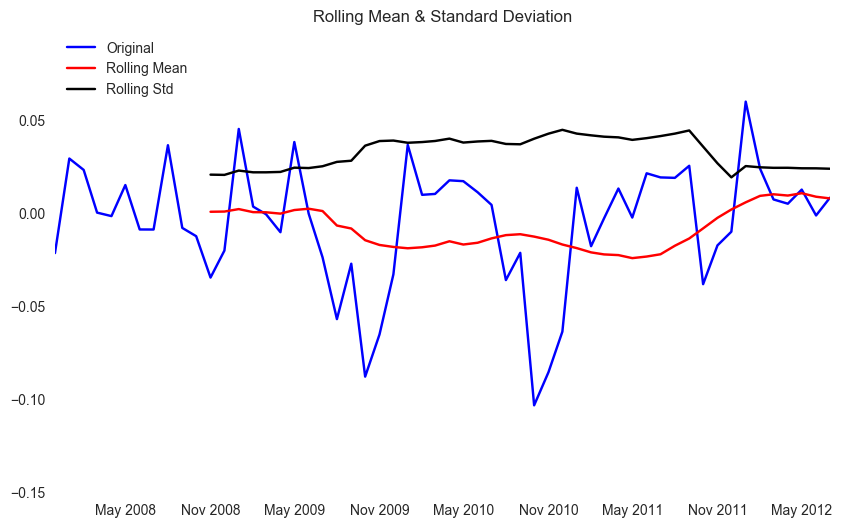

Results of Dickey-Fuller Test:
Test Statistic                 -0.671858
p-value                         0.853905
#Lags Used                     11.000000
Number of Observations Used    44.000000
Critical Value (5%)            -2.929886
Critical Value (1%)            -3.588573
Critical Value (10%)           -2.603185
dtype: float64


In [243]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

### 2. Exponentially Weighted Moving Average

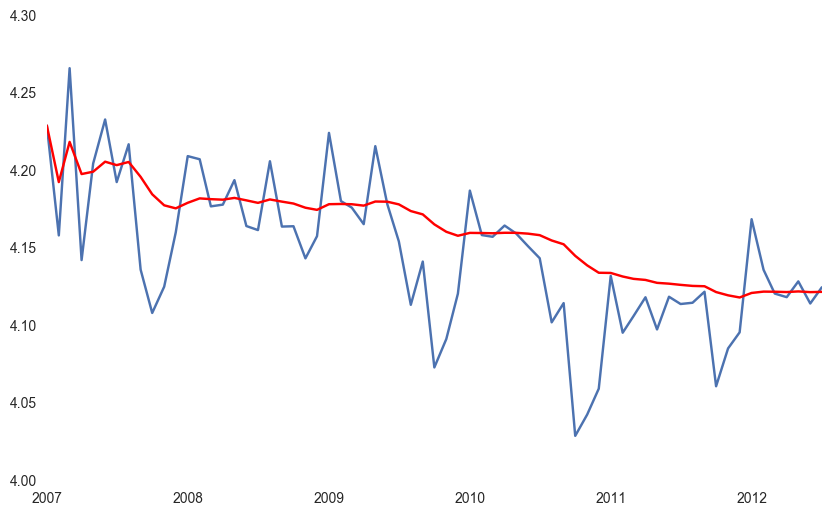

In [244]:
expwighted_avg = pd.ewma(train['mean'], halflife=12)
plt.plot(train['mean'])
plt.plot(expwighted_avg, color='red')
plt.show()

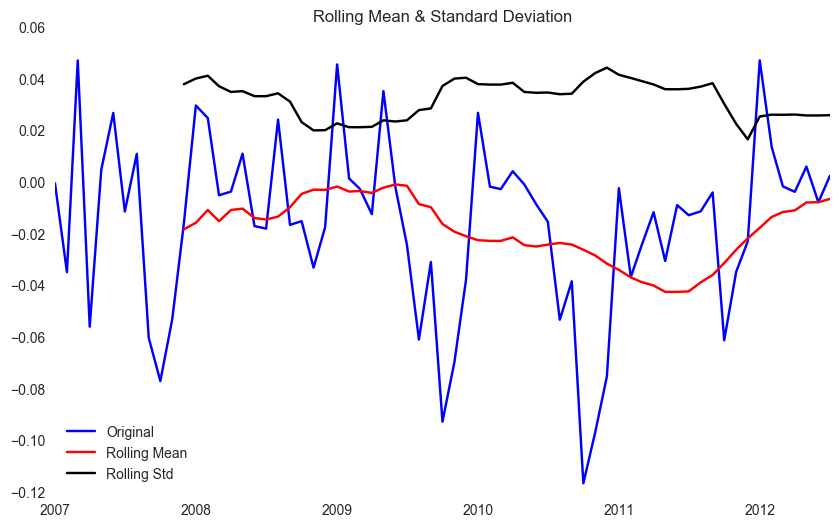

Results of Dickey-Fuller Test:
Test Statistic                 -0.832974
p-value                         0.809244
#Lags Used                     11.000000
Number of Observations Used    55.000000
Critical Value (5%)            -2.915731
Critical Value (1%)            -3.555273
Critical Value (10%)           -2.595670
dtype: float64


In [245]:
ts_log_ewma_diff = train['mean'] - expwighted_avg
test_stationarity(ts_log_ewma_diff)

### 3. Differencing

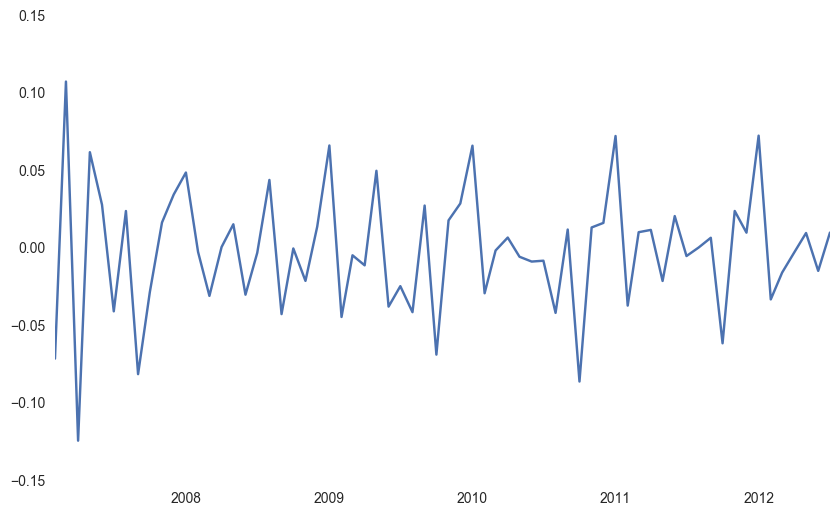

In [246]:
ts_log_diff = train['mean'] - train['mean'].shift()
plt.plot(ts_log_diff)

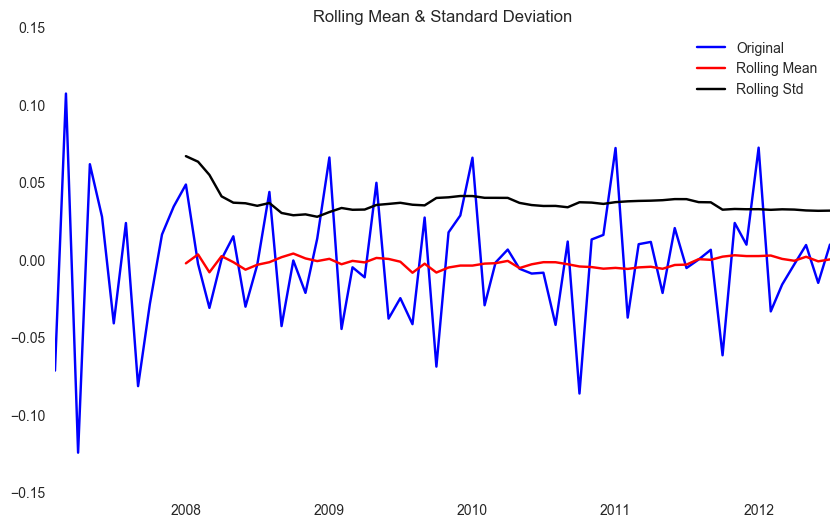

Results of Dickey-Fuller Test:
Test Statistic                 -3.051280
p-value                         0.030375
#Lags Used                     11.000000
Number of Observations Used    54.000000
Critical Value (5%)            -2.916770
Critical Value (1%)            -3.557709
Critical Value (10%)           -2.596222
dtype: float64


In [247]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### 4. Decomposing

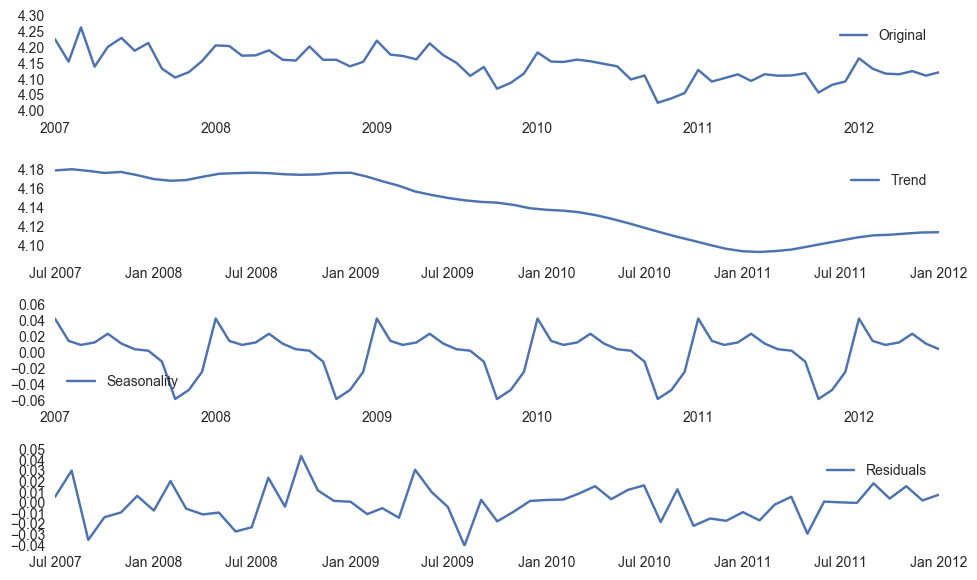

In [248]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train['mean'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(train['mean'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

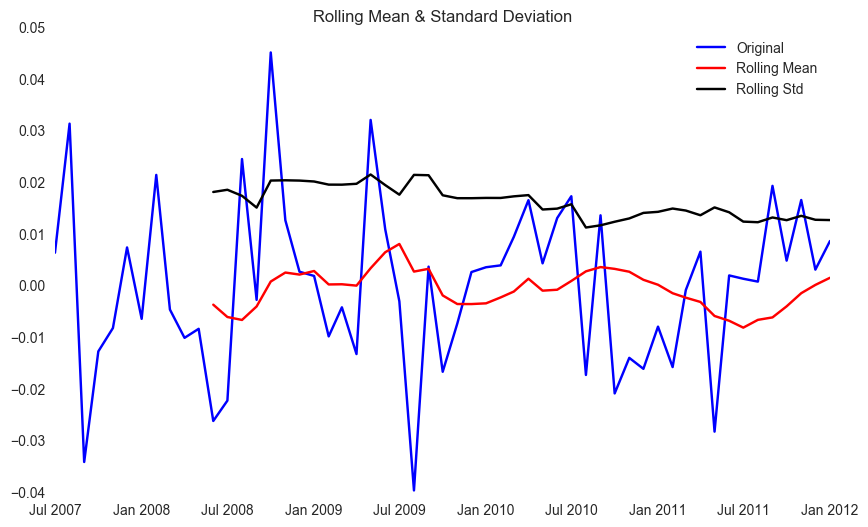

Results of Dickey-Fuller Test:
Test Statistic                 -4.374172
p-value                         0.000330
#Lags Used                     10.000000
Number of Observations Used    44.000000
Critical Value (5%)            -2.929886
Critical Value (1%)            -3.588573
Critical Value (10%)           -2.603185
dtype: float64


In [249]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

## Forecasting a Time Series

In [250]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

The Autocorrelation Function measures how a variable is correlated with itself at different time periods. To compute autocorrelation, we fix a lag 'k' that measures how correlated a value is with its value k periods prior. In other words, a k of 10 measures how correlated the current value is with the one ten time periods before.

In [251]:
## The Autocorrelation function plotted with the

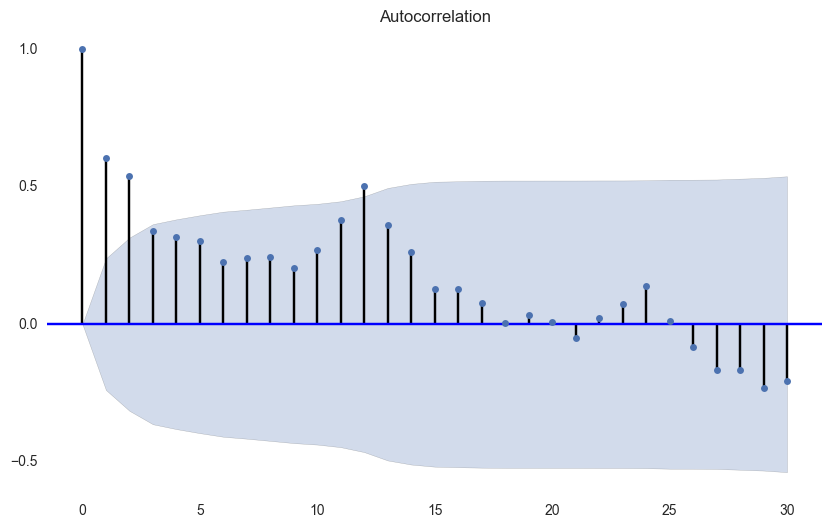

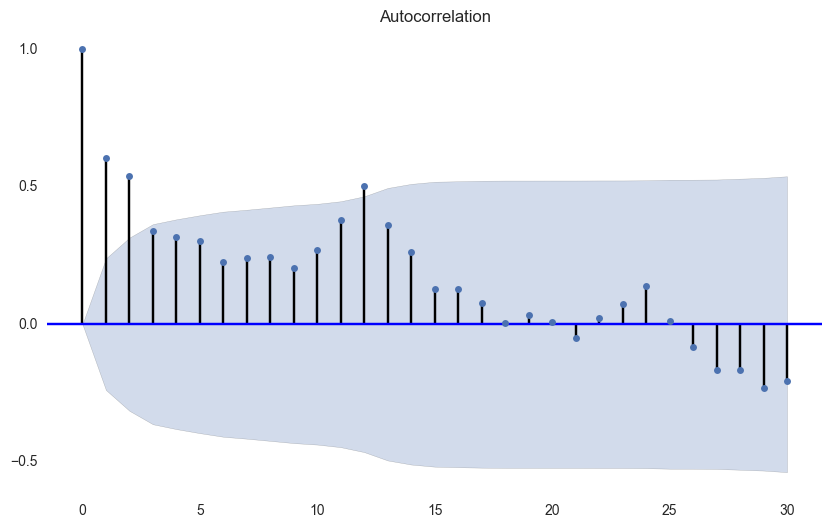

In [252]:
plot_acf(train['mean'],lags=30)

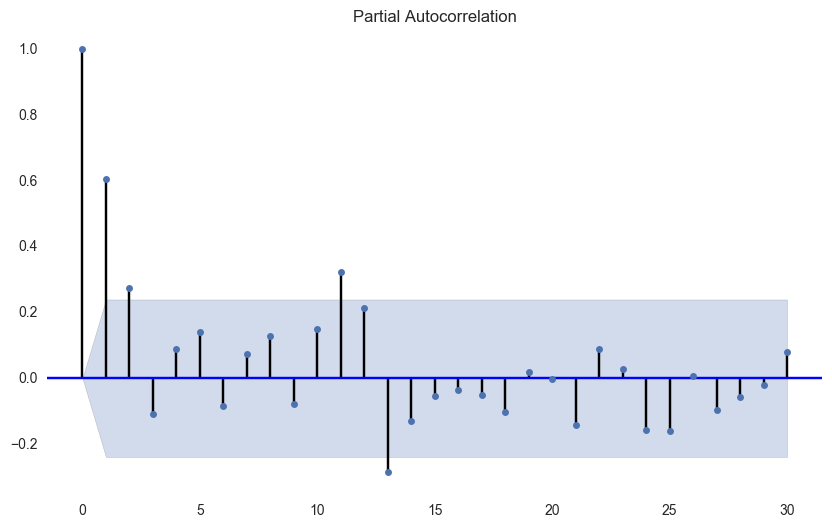

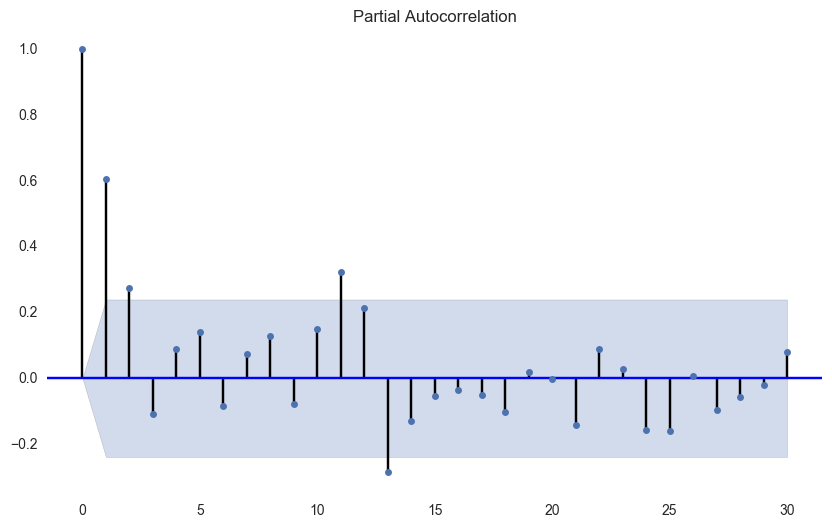

In [253]:
plot_pacf(train['mean'],lags=30)

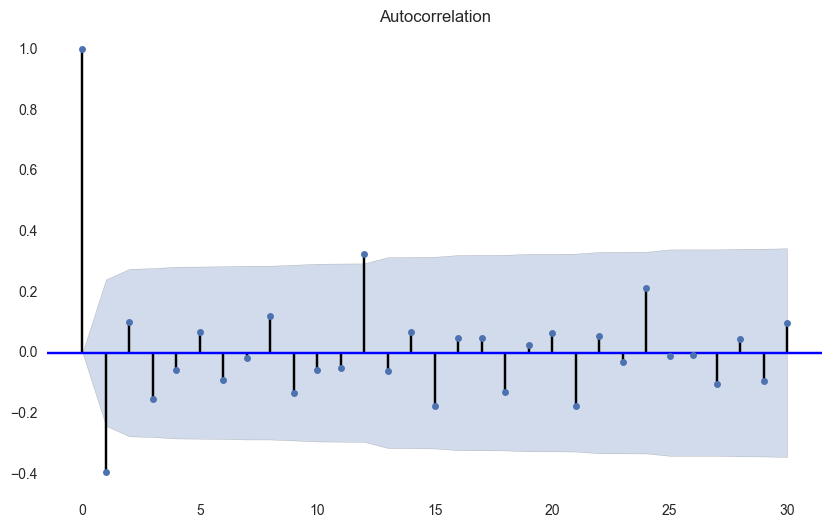

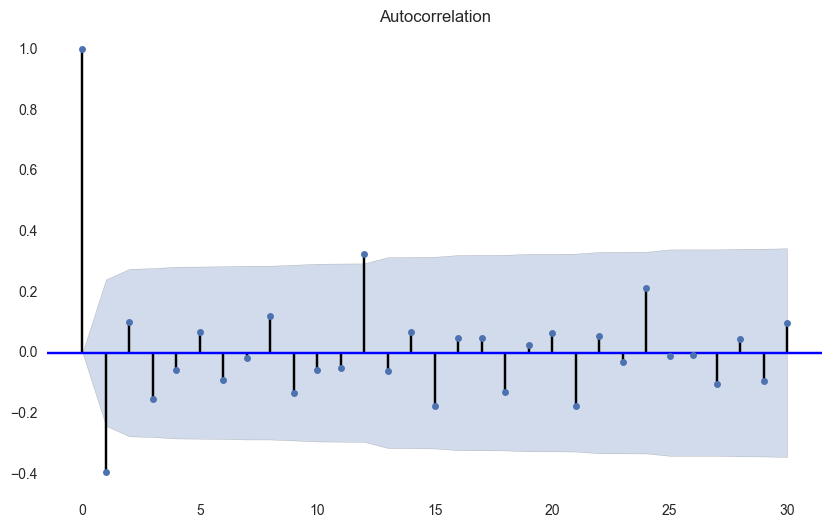

In [254]:
plot_acf(ts_log_diff,lags=30)

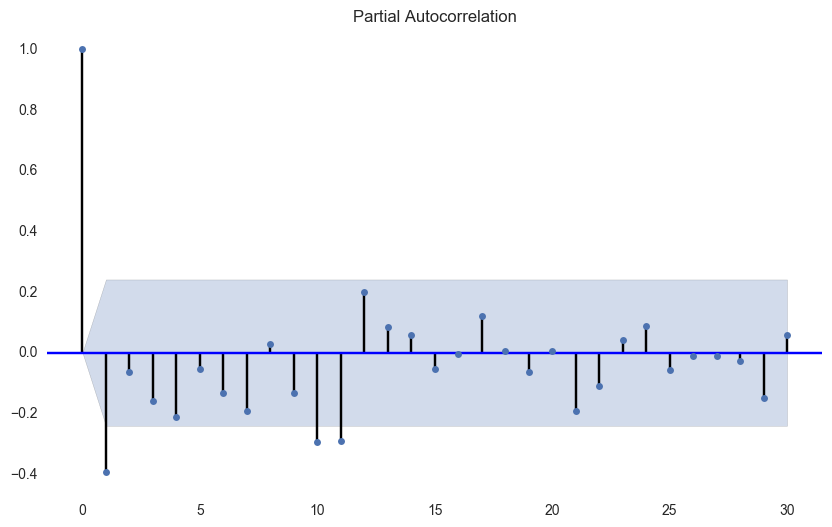

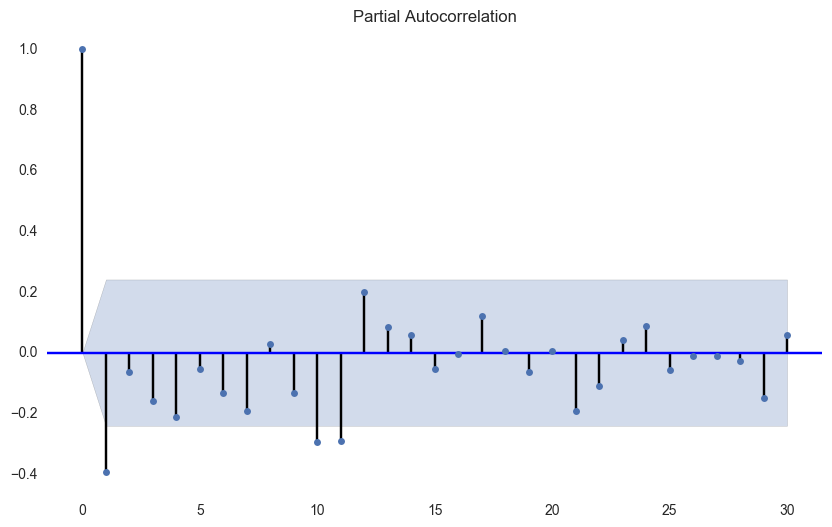

In [255]:
plot_pacf(ts_log_diff,lags=30)

### Takeaways
For an ARIMA model, we need to determine p, q, and d. 

p: Number of AR (Auto-Regressive) terms  
q: Number of MA (Moving Average) terms   
d: Number of Differences (d)   

For our ARIMA model:
p = 1
q = 1

In [256]:
from statsmodels.tsa.arima_model import ARIMA

## AR Model

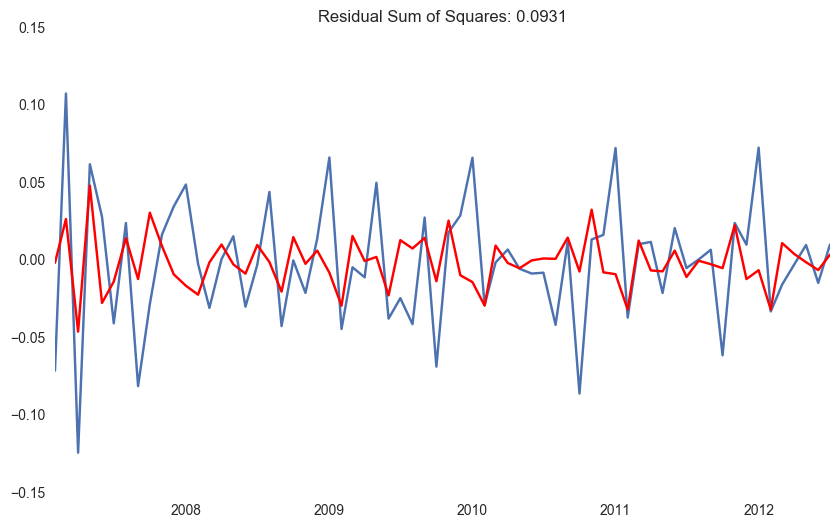

In [257]:
model = ARIMA(train['mean'], order=(1, 1, 0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('Residual Sum of Squares: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.show()

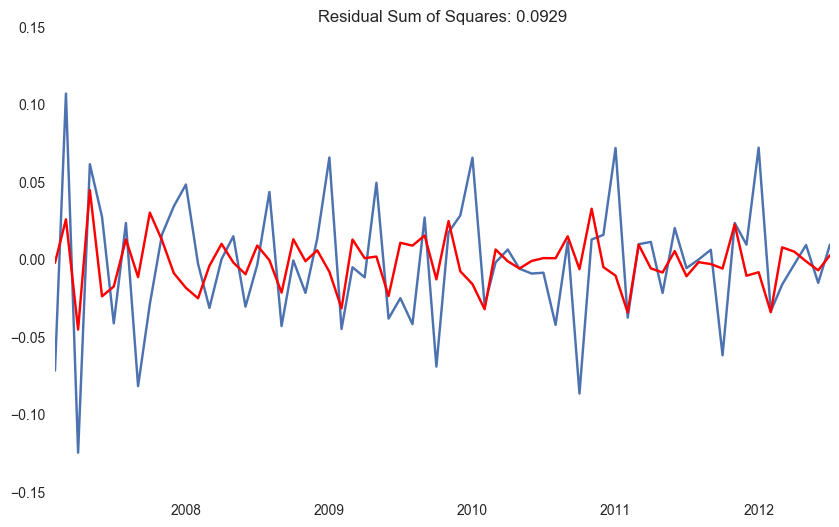

In [258]:
model = ARIMA(train['mean'], order=(2, 1, 0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('Residual Sum of Squares: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.show()

## MA Model

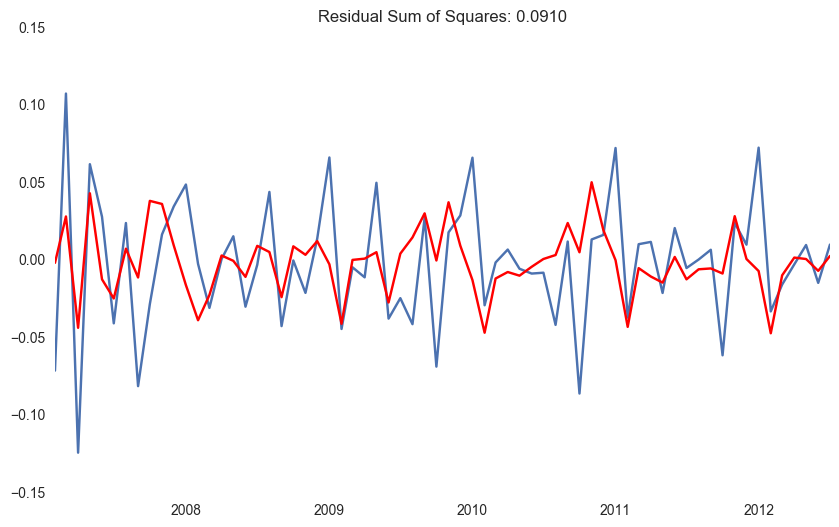

In [259]:
model = ARIMA(train['mean'], order=(0, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('Residual Sum of Squares: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.show()

In [260]:
# p_list = range(0,20)
# q_list = range(0,3)
# all_combinations = pd.DataFrame(columns=['order','residual_sum_squares'])

# for p in p_list:
#     for q in q_list:
#         try:
#             model = ARIMA(train['mean'], order=(p, 1, q))
#             results_ARIMA = model.fit(disp=-1)
#             RSS = sum((results_ARIMA.fittedvalues-ts_log_diff)**2)
#             order = (p,1,q)
#             all_combinations = all_combinations.append({'order':order,'residual_sum_squares': RSS},ignore_index=True)
#         except:
#             continue

In [261]:
#all_combinations.head()

## Combined ARIMA Model

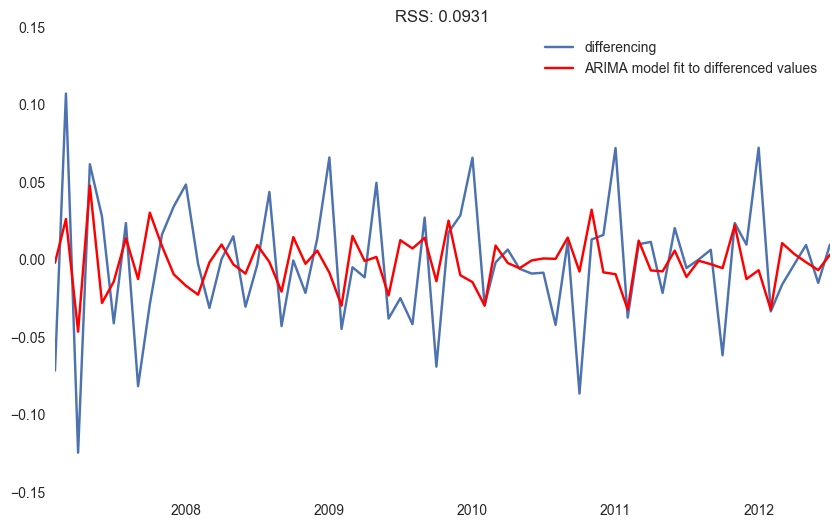

In [262]:
model = ARIMA(train['mean'], order=(1, 1, 0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff,label='differencing')
plt.plot(results_ARIMA.fittedvalues, color='red',label='ARIMA model fit to differenced values')
plt.legend()
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.show()

In [264]:
predictions = results_ARIMA.predict(
    '2012-08-01',
    '2014-07-01',
    dynamic=False
)

In [265]:
results_ARIMA.fittedvalues.head()

date
2007-02-01   -0.001328
2007-03-01    0.026940
2007-04-01   -0.045724
2007-05-01    0.048464
2007-06-01   -0.027200
dtype: float64

In [266]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

date
2007-02-01   -0.001328
2007-03-01    0.026940
2007-04-01   -0.045724
2007-05-01    0.048464
2007-06-01   -0.027200
dtype: float64


In [267]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

date
2007-02-01   -0.001328
2007-03-01    0.025612
2007-04-01   -0.020112
2007-05-01    0.028351
2007-06-01    0.001152
dtype: float64


In [268]:
predictions_ARIMA_log = pd.Series(train['mean'].ix[0], index=train['mean'].index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

date
2007-01-01    4.229490
2007-02-01    4.228162
2007-03-01    4.255102
2007-04-01    4.209378
2007-05-01    4.257842
dtype: float64

In [269]:
results_ARIMA

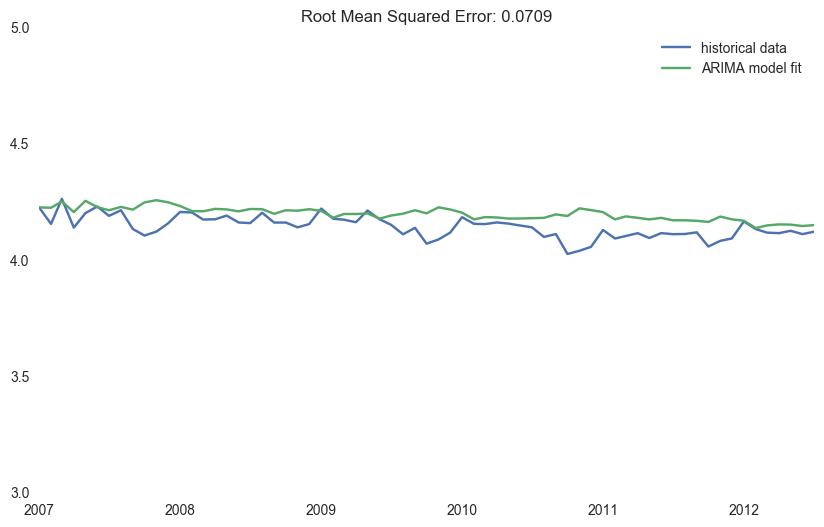

In [270]:
predictions_ARIMA = predictions_ARIMA_log
plt.plot(train['mean'], label='historical data')
plt.plot(predictions_ARIMA,label='ARIMA model fit')
#plt.plot(results_ARIMA)
plt.legend()
plt.ylim(3,5)
plt.title('Root Mean Squared Error: %.4f'% np.sqrt(sum((predictions_ARIMA-train['mean'])**2)/len(train['mean'])))
plt.show()

In [271]:
test

,mean,var,stddev,pval
date,,,,
2012-08-01,4.102333,1.675925,1.294575,1.798581e-15
2012-09-01,4.108073,1.673669,1.293704,1.392734e-13
2012-10-01,4.130674,1.582713,1.258059,1.368651e-04
2012-11-01,4.158863,1.514581,1.230683,7.880629e-05
2012-12-01,4.223174,1.410866,1.187799,2.123993e-233
2013-01-01,4.244016,1.368890,1.169996,0.000000e+00
2013-02-01,4.218983,1.431778,1.196569,1.762804e-163
2013-03-01,4.214538,1.413936,1.189090,9.702491e-147
2013-04-01,4.196565,1.412106,1.188321,9.214394e-81


In [272]:
from sklearn.metrics import mean_absolute_error

In [309]:
model = ARIMA(train['mean'], (2,1,1)).fit(disp=-1)

predictions = model.predict(
    '2012-08-01',
    '2014-07-01',
    dynamic=False, 
    typ='levels'
)

In [310]:
predictions

2012-08-01    4.118978
2012-09-01    4.119700
2012-10-01    4.117485
2012-11-01    4.116558
2012-12-01    4.115048
2013-01-01    4.113810
2013-02-01    4.112441
2013-03-01    4.111138
2013-04-01    4.109801
2013-05-01    4.108481
2013-06-01    4.107152
2013-07-01    4.105828
2013-08-01    4.104502
2013-09-01    4.103176
2013-10-01    4.101851
2013-11-01    4.100525
2013-12-01    4.099199
2014-01-01    4.097874
2014-02-01    4.096548
2014-03-01    4.095222
2014-04-01    4.093897
2014-05-01    4.092571
2014-06-01    4.091245
2014-07-01    4.089920
Freq: MS, dtype: float64

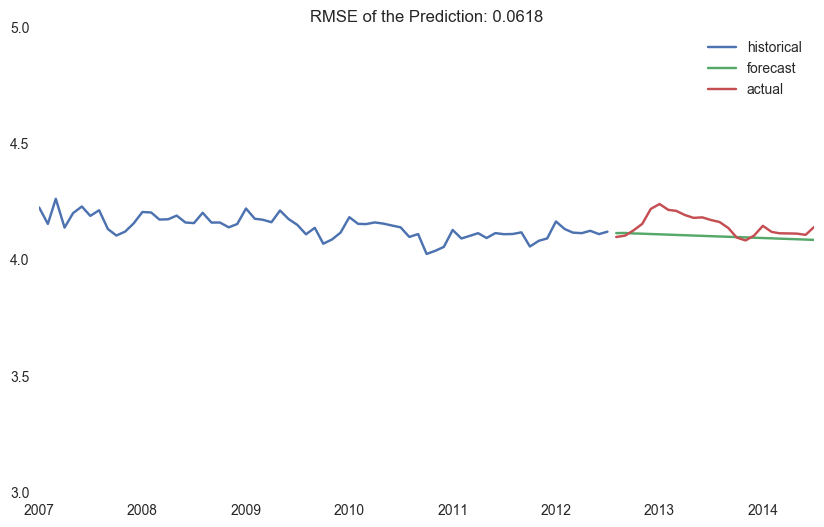

In [311]:
plt.plot(train['mean'], label='historical')
plt.plot(predictions,label='forecast')
plt.plot(test['mean'],label='actual')
plt.ylim(3,5)
plt.legend(loc='best')
plt.title('RMSE of the Prediction: %.4f'% np.sqrt(sum((predictions-test['mean'])**2)/len(test['mean'])))
plt.show()

## Additional Interesting Questions to Explore

* Why are review ratings on average declining over time? With item and user data, further investigation on if there are more "bad" items or traits of the user (i.e. more returns?) that lead to a negative experience. Digging into the text of the reviews data may also provide additional clues.
* Are the fluctuations normal? Are the peaks and dips statistically significant? What can we understand about seasonality of the business?
* Given a reviewierID and a product_id (asin), can we predict what a user rating will be for a product they haven't seen yet? This helps us determine customer affinity for new products and can be used as a recommender system either on-site or via email.
* Using timeseries prediction, can we model predicted average review rating by month for the rest of the year?
* These are Amazon review ratings for a particular category (Clothing, Shoes, and Jewelry) -- do we see similar trends in other categories?